In [1]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import warnings,os,time,datetime,math,itertools

import torch
import pandas as pd

from keras.models import Model
from keras.layers import Dense,Input,Activation,LSTM,Conv1D,Conv2D,Dropout,BatchNormalization,concatenate

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [111]:
def determine_reorder_qty_naive(c_stock,sbar_mean_est,Ts,alpha,beta):
    if ((c_stock/sbar_mean_est)-Ts)<=beta:
        reorder_qty = alpha*sbar_mean_est*Ts
    else:
        reorder_qty = 0
    return round(reorder_qty)

In [112]:
sbar_mean = 2

In [113]:
sbar_mean_est = 2
Ts = 2

In [178]:
price_purchase_pp = lambda x: 0 if x<=0 else 5 if x<10 else 2 if x<50 else 1
price_stocked_pp = lambda x: 0 if x<=0 else 2*int(np.ceil(x/10))

price_sold_pp = 4

In [192]:
placedOrders = []

dateL = []
orderdL = []
deliveredL = []
stockL = []
arrivingL = []
missedL = []

exp_neworders = []
exp_stock = []
rev_sold = []

Nmonths = 36
c_stock = 15
c_date = pd.to_datetime('2018-01-01')

for k in range(Nmonths):
    
    stockL.append(c_stock)
    
    c_num_reorder = determine_reorder_qty_naive(
        c_stock,
        sbar_mean_est,
        Ts,
        alpha=1,
        beta=1
    )
    placedOrders.append(c_num_reorder)
    
    c_arriving = 0 if len(placedOrders)<=Ts else placedOrders[-Ts]
    arrivingL.append(c_arriving)
    
    c_orders = rnd.poisson(lam=sbar_mean)
    c_delivered = c_orders if (c_stock-c_orders)>0 else c_stock
    c_missed = c_orders - c_delivered
    missedL.append(c_missed)
    
    exp_neworders.append((-1)*(price_purchase_pp(c_num_reorder)))
    exp_stock.append((-1)*(price_stocked_pp(c_stock)))
    rev_sold.append(c_orders*price_sold_pp)
    
    c_stock = c_stock - c_delivered + c_arriving
    
    dateL.append(c_date)
    orderdL.append(c_orders)
    deliveredL.append(c_delivered)
    
    c_date = c_date + pd.DateOffset(months=1)

df = pd.DataFrame([dateL,stockL,orderdL,deliveredL,placedOrders,arrivingL,missedL,exp_neworders,exp_stock,rev_sold]).transpose().rename(columns={
    0:'Date',
    1:'Current Stock',
    2:'Incoming Orders',
    3:'Served Orders',
    4:'Placed new Orders',
    5:'Newly Arriving',
    6:'Missed',
    7:'New Orders Costs',
    8:'Stocked Cost',
    9:'Revenue'
}).set_index('Date')

df['Partial EBIT'] = df[['New Orders Costs','Stocked Cost','Revenue']].apply(lambda x: sum(x),axis=1)

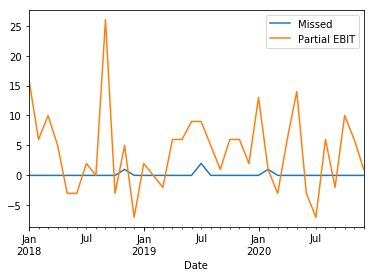

In [193]:
df[['Missed','Partial EBIT']].plot()

In [190]:
df

,Current Stock,Incoming Orders,Served Orders,Placed new Orders,Newly Arriving,Missed,New Orders Costs,Stocked Cost,Revenue,Partial EBIT
Date,,,,,,,,,,
2018-01-01,15,2,2,4,0,0,-5,-4,8,-1
2018-02-01,13,3,3,4,0,0,-5,-4,12,3
2018-03-01,10,5,5,4,4,0,-5,-2,20,13
2018-04-01,9,2,2,4,4,0,-5,-2,8,1
2018-05-01,11,1,1,4,4,0,-5,-4,4,-5
2018-06-01,14,2,2,4,4,0,-5,-4,8,-1
2018-07-01,16,4,4,4,4,0,-5,-4,16,7
2018-08-01,16,2,2,4,4,0,-5,-4,8,-1
2018-09-01,18,1,1,4,4,0,-5,-4,4,-5
